In [7]:
import warnings
warnings.filterwarnings("ignore")
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import time

In [8]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
Y = raw_df.values[1::2, 2]

In [9]:
print(X.shape)
# 506 samples and 13 features

(506, 13)


In [10]:
print("Mean : {}".format(X.mean()))
print("Max  : {}".format(X.max()))
print("Min  : {}".format(X.min()))

Mean : 70.07396704469443
Max  : 711.0
Min  : 0.0


In [11]:
print(Y.shape)
# Target is the house price in each sample

(506,)


In [12]:
# scaling the data for faster gradient descent
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [15]:
print("Mean : {}".format(X.mean()))
print("Max  : {}".format(X.max()))
print("Min  : {}".format(X.min()))

Mean : -1.658077074174147e-16
Max  : 9.933930601860267
Min  : -3.9071933049810412


In [17]:
clf = SGDRegressor()
clf.fit(X, Y)
print(mean_squared_error(Y, clf.predict(X)))

21.91895714461863


#### Implementing our own gradient descent function

In [19]:
samples = X.shape[0]
iterations = 300

In [22]:
# Adding the 'bias' column with the features columns
X = np.c_[np.ones(samples), X]

In [23]:
# shuffle data X and Y
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]

In [24]:
Y = Y.reshape(Y.shape[0], 1)

In [25]:
X.shape

(506, 14)

In [27]:
def gradient_descent(X, Y, learning_rate=0.01, iterations=400, batch_Size=0):
    # Perform sanity checks to ensure input data is correctly shaped
    assert(Y.shape == (X.shape[0], 1))  # Ensure Y is a column vector matching X's number of samples
    assert(batch_Size >= 0)  # Ensure batch_Size is non-negative

    samples = X.shape[0]  # Total number of samples in the dataset

    start = time.time()  # Start timing the execution of the function

    # Initialize theta (parameters) randomly for all features including bias
    theta = np.random.randn(X.shape[1], 1)
    # Initialize an array to record the cost (loss) values at each iteration
    cost_hist = np.zeros(iterations)

    for i_num in range(iterations):
        # Case for Gradient Descent: use all data
        if batch_Size == 0:
            prediction = np.dot(X, theta)  # Calculate predictions for the current theta
            # Update theta by subtracting the gradient scaled by the learning rate
            theta -= (1/samples) * learning_rate * np.dot(X.T, prediction - Y)
            # Recalculate predictions and compute the cost (mean squared error)
            prediction = np.dot(X, theta)
            cost_hist[i_num] = np.sum(np.square(prediction - Y)) / (2 * samples)

        # Case for Stochastic Gradient Descent: use one sample at a time
        elif batch_Size == 1:
            cost = 0.0
            for s in range(samples):  # Iterate through each sample
                X_i = X[s, :].reshape(1, X.shape[1])  # Get the current sample's features
                Y_i = Y[s].reshape(1, 1)  # Get the current sample's target value
                prediction = np.dot(X_i, theta)  # Make a prediction for the current sample
                # Update theta for the current sample
                theta -= learning_rate * np.dot(X_i.T, prediction - Y_i)
                # Recalculate prediction and compute the cost for the current sample
                prediction = np.dot(X_i, theta)
                cost += np.sum(np.square(prediction - Y_i)) / 2
            cost_hist[i_num] = cost / samples  # Average cost over all samples

        # Case for Mini-Batch Gradient Descent: use a subset of data
        else:
            cost = 0.0
            n_batches = samples // batch_Size  # Determine the number of batches
            batches = np.random.permutation(samples - batch_Size + 1)[:n_batches]
            for bat in batches:  # Iterate over each batch
                # Select the batch of data
                X_i = X[bat: bat + batch_Size]
                Y_i = Y[bat: bat + batch_Size]
                prediction = np.dot(X_i, theta)  # Make predictions for the batch
                # Update theta based on the batch's data
                theta -= (1 / batch_Size) * learning_rate * np.dot(X_i.T, prediction - Y_i)
                # Recalculate predictions and compute cost for the batch
                prediction = np.dot(X_i, theta)
                cost += np.sum(np.square(prediction - Y_i)) / (2 * batch_Size)
            cost_hist[i_num] = cost / batch_Size  # Average cost over all batches

    end = time.time()  # End timing the execution
    print("Run time : {} ms".format(round((end - start) * 1000, 2)))  # Print execution time

    return theta, cost_hist  # Return the optimized parameters and the cost history


In [28]:
# Batch gradient descent
theta_gd, cost_hist_gd = gradient_descent(X, Y,
                        iterations=iterations, batch_Size=0)

Run time : 33.65 ms


In [29]:
# stochastic gradient descent
theta_sgd, cost_hist_sgd = gradient_descent(X, Y,
                        iterations=iterations, batch_Size=1)

Run time : 3719.47 ms


In [30]:
# mini-batch gradient descent
theta_mbgd, cost_hist_mbgd = gradient_descent(X, Y,
                        iterations=iterations, batch_Size=25)

Run time : 108.34 ms


####  Comparing the cost history graphs

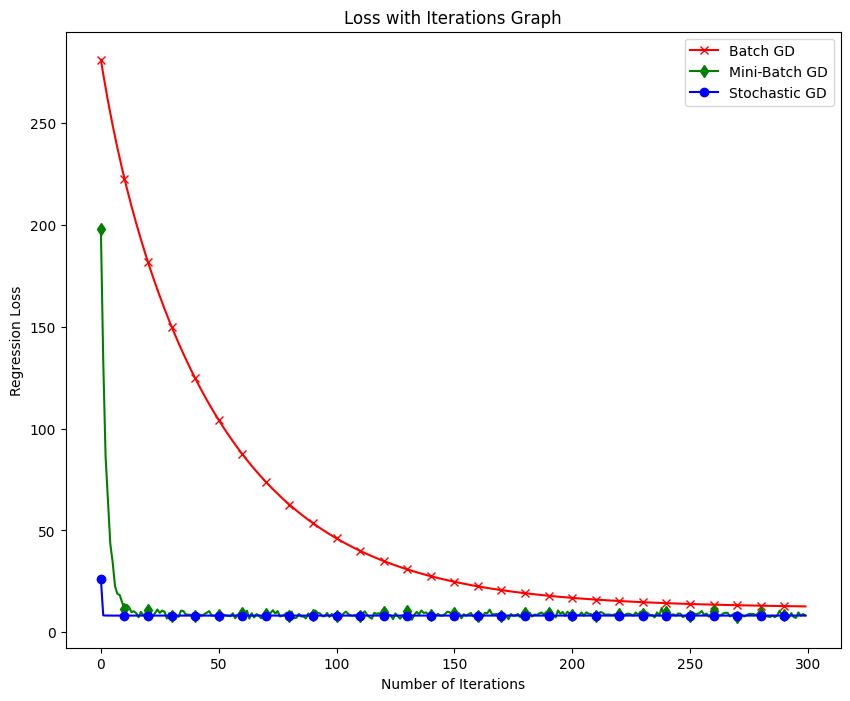

In [31]:
# Plotting the cost values with iterations graph
x_axis = range(iterations)
plt.figure(figsize=(10.0, 8.0))
markers_on = [i for i in range(iterations) if i%10 ==0]
plt.plot(x_axis, cost_hist_gd, '-rx', markevery=markers_on,
                     label='Batch GD', )
plt.plot(x_axis, cost_hist_mbgd, '-gd', markevery=markers_on,
                     label='Mini-Batch GD')
plt.plot(x_axis, cost_hist_sgd, '-bo', markevery=markers_on,
                     label='Stochastic GD')
plt.xlabel("Number of Iterations")
plt.ylabel("Regression Loss")
plt.title("Loss with Iterations Graph")
plt.legend()
plt.show()

In [32]:
clf = SGDRegressor()
clf.fit(X, Y)
pred_sklearnSGD = clf.predict(X)
print(mean_squared_error(Y, pred_sklearnSGD))

21.99469035271588


#### Finding most optimal theta

In [33]:
# Since the number of features are not too large and our computational
# power is sufficient, lets directly find the optimal value of theta by
# using the vectorised normal equation

theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
print(theta_best)

[[ 2.25328063e+01]
 [-9.28146064e-01]
 [ 1.08156863e+00]
 [ 1.40899997e-01]
 [ 6.81739725e-01]
 [-2.05671827e+00]
 [ 2.67423017e+00]
 [ 1.94660717e-02]
 [-3.10404426e+00]
 [ 2.66221764e+00]
 [-2.07678168e+00]
 [-2.06060666e+00]
 [ 8.49268418e-01]
 [-3.74362713e+00]]


In [34]:
# Lets compare the Cost value from our gradient descent functions and the
# one we get using the most optimal theta value, 'theta_best'

pred_best = X.dot(theta_best)
print("Error from Optimal Theta : {}".format(mean_squared_error(Y,
                                    pred_best)))
pred_gd = X.dot(theta_gd)
print("Error from Calculated Theta for Batch GD: {}".format(
                                mean_squared_error(Y, pred_gd)))
pred_mbgd = X.dot(theta_mbgd)
print("Error from Calculated Theta for Mini-Batch GD: {}".format(
                                mean_squared_error(Y, pred_mbgd)))
pred_sgd = X.dot(theta_sgd)
print("Error from Calculated Theta for Stochastic GD: {}".format(
                                mean_squared_error(Y,pred_sgd)))

print("Error from Calculated Theta for skLearn SGD: {}".format(
                                mean_squared_error(Y,pred_sklearnSGD)))

Error from Optimal Theta : 21.894831181729206
Error from Calculated Theta for Batch GD: 25.415635403626347
Error from Calculated Theta for Mini-Batch GD: 21.995530990984378
Error from Calculated Theta for Stochastic GD: 22.422176084792422
Error from Calculated Theta for skLearn SGD: 21.99469035271588


In [35]:
print("Comparing the weights from our SGD and skLearn Regressor: ")
sklSGD = clf.coef_
for i in range(len(sklSGD)):
    print("  {0:2d} :  {1: 10.8f}   -   {2: 10.8f}". format(
                    i+1,
                    theta_sgd[i][0],
                    sklSGD[i]))

Comparing the weights from our SGD and skLearn Regressor: 
   1 :   22.62229753   -    11.28089313
   2 :  -0.63572668   -   -0.86042478
   3 :   1.13393462   -    0.98997786
   4 :   0.02072067   -   -0.15103172
   5 :   1.17306014   -    0.74115145
   6 :  -2.10603468   -   -1.91627227
   7 :   2.59562687   -    2.75672507
   8 :  -0.06309510   -   -0.05560601
   9 :  -2.93000153   -   -3.00006481
  10 :   3.02681727   -    1.93508925
  11 :  -2.63297470   -   -1.29639258
  12 :  -2.12604138   -   -2.01130400
  13 :   1.06222930   -    0.87540033
  14 :  -3.54684460   -   -3.72860133


#### Comparing the predictions of our SGD, sklearn SGD and the actual Values

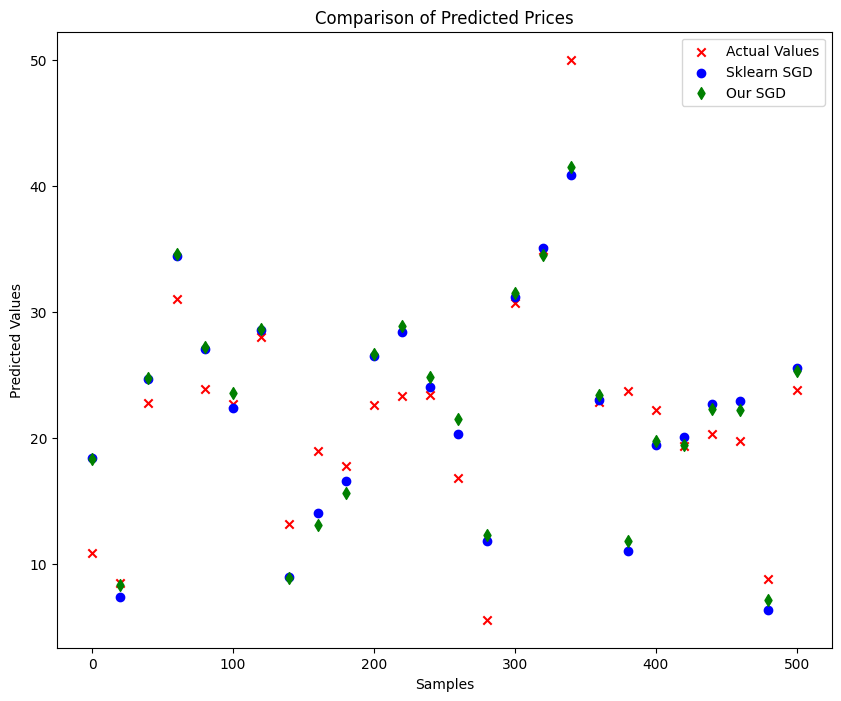

In [36]:
# Take 25 samples from the 506 samples
x_axis = [i for i in range(samples) if i%20==0]
plt.figure(figsize=(10.0, 8.0))
plt.scatter(x_axis, Y[x_axis], marker='x',
                    color='r', label='Actual Values')
plt.scatter(x_axis, pred_sklearnSGD[x_axis], marker='o',
                    color='b', label='Sklearn SGD')
plt.scatter(x_axis, pred_sgd[x_axis], marker='d',
                    color='g', label='Our SGD')
plt.xlabel("Samples")
plt.ylabel("Predicted Values")
plt.title("Comparison of Predicted Prices")
plt.legend()
plt.show()

In [ ]:
# Hence, we see we were able to beat the SGD regressor score but we couldn't
# surpass the score we got from the optimal value of theta